##CM3111 Assessment
#Water well logs interpretation using machine learning


##1.1	Dataset
The dataset comprises geophysical well logs data pertaining to deep water wells located in Saudi Arabia. I was an integral member of the geologists' team responsible for the collection, processing, and interpretation of these data, specifically for underground water projects spanning the period from 2012 to 2019.
The selection of this dataset is motivated by the potential it holds in offering a significant contribution to the field of geophysical water exploration.


##1.2	Related Work & Data Exploration.
#1. Dataset Overview
The dataset is a geophysical well logs records includes parameters such as natural gamma ray emissions, electric resistivity, density, temperature, spontaneous potential, and neutron counts. It is utilized for the purpose of identifying water-bearing zones within the subsurface through the interpretation of these logs. The freshwater zone exhibits distinctive characteristics in the logs, including low gamma ray emissions, a semi-linear and consistent decrease in the separation between short and long resistivity curves, and a relatively high neutron count.


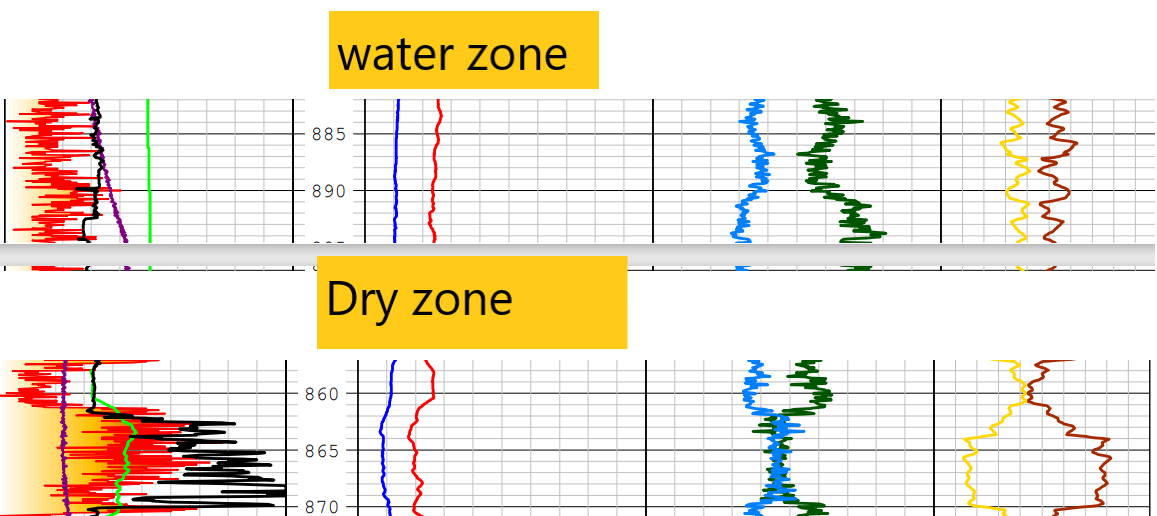

##*2*.Objectives:
The primary objective is to use this dataset  to serve as the foundation for constructing a robust Machine Learning model. This model will possess the capability to discern various log curve behaviors, enabling it to accurately pinpoint water-bearing zones within the provided well logs.


# 3.Peer-reviewed paper:

#4. Data Loading & Exploration:

In [142]:
# import required variables
import pandas as pd
import numpy as np

In [143]:
# Loading Dataset
df = pd.read_csv('/content/sample_data/WellLoging_Dataset.csv')
print(df.columns)


Index(['Well_ID', 'Depth', 'GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON',
       'Interpretation', 'Interpretation_N'],
      dtype='object')


In [144]:
# Display basic information about the dataset
print("Dataset Information:")
print(df.info())

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

# View the first few rows of the dataset
print("\nFirst Few Rows:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30685 entries, 0 to 30684
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Well_ID           30685 non-null  object 
 1   Depth             30685 non-null  float64
 2   GAM(NAT)          30685 non-null  float64
 3   RES(16N)          30685 non-null  float64
 4   RES(64N)          30685 non-null  float64
 5   NEUTRON           30685 non-null  float64
 6   Interpretation    30685 non-null  object 
 7   Interpretation_N  30685 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.9+ MB
None

Summary Statistics:
              Depth      GAM(NAT)      RES(16N)      RES(64N)       NEUTRON  \
count  30685.000000  30685.000000  30685.000000  30685.000000  30685.000000   
mean     447.349076     66.606170    129.643993    253.448386    848.484463   
std      180.893172     65.838504     55.991054    148.724928    225.229816 

In [145]:
df.groupby('Interpretation').mean()

<ipython-input-145-9577cd330b70>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Interpretation').mean()


,Depth,GAM(NAT),RES(16N),RES(64N),NEUTRON,Interpretation_N
Interpretation,,,,,,
Dry,404.919702,124.288041,71.706603,94.604321,681.340862,0.0
Water,474.973258,29.051656,167.364866,356.865829,957.305425,1.0


In [146]:
# Checking for missing values
df.isnull().sum()

Well_ID             0
Depth               0
GAM(NAT)            0
RES(16N)            0
RES(64N)            0
NEUTRON             0
Interpretation      0
Interpretation_N    0
dtype: int64

In [147]:
# Selecting the feature
df = pd.read_csv('/content/sample_data/WellLoging_Dataset.csv', usecols=['Well_ID', 'Depth','GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON',
       'Interpretation', 'Interpretation_N'])

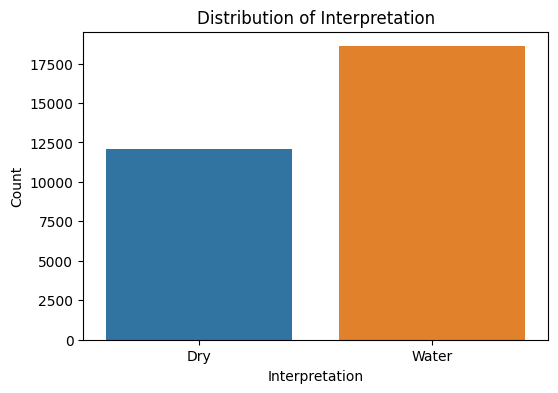

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize Interpretation
plt.figure(figsize=(6, 4))
sns.countplot(x='Interpretation', data=df)
plt.title('Distribution of Interpretation')
plt.xlabel('Interpretation')
plt.ylabel('Count')
plt.show()



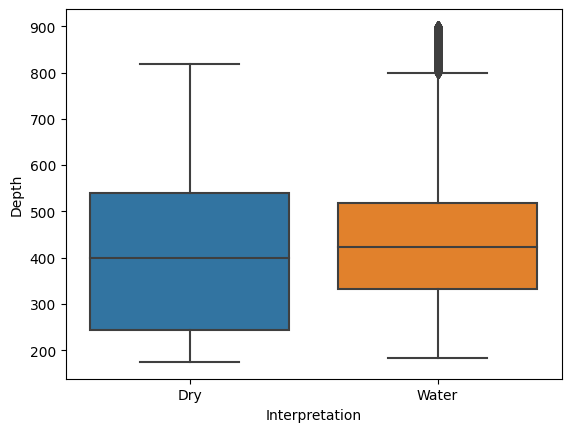

In [149]:
# Visualize Interpretation Vs Depth
sns.boxplot(data= df, x='Interpretation',y='Depth')
plt.show()


#1.3 Data Pre-processing

"This dataset contains information for six different water wells logs. I merged them into one csv file and added a column for the well ID,  in order to prepare the data for regression modeling. I converted the outcome into a numeric value instead of a classification (Water/Dry). I replaced 'Water' with '1' and 'Dry' with '0'."

In [26]:
# data cleaning to remove outliers, as well as three different types of data scaling: Min-Max normalization, Standard Scaling (Z-Score Standardization), and Robust Scaling.

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


def clean_and_scale_data(df, columns, threshold=3, scale_method='min_max'):
    df_clean = df.copy()

    # Remove outliers and apply scaling
    for column in columns:
        # Remove outliers using Robust Scaling
        median = df_clean[column].median()
        iqr = df_clean[column].quantile(0.75) - df_clean[column].quantile(0.25)
        z_scores = (df_clean[column] - median) / iqr
        outliers = (z_scores.abs() > threshold)
        df_clean.loc[outliers, column] = median  # Replace outliers with median

        # Apply scaling
        if scale_method == 'min_max':
            scaler = MinMaxScaler()
        elif scale_method == 'standard':
            scaler = StandardScaler()
        elif scale_method == 'robust':
            scaler = RobustScaler()
        else:
            raise ValueError("Invalid scale_method. Use 'min_max', 'standard', or 'robust'.")

        df_clean[[column]] = scaler.fit_transform(df_clean[[column]])

    return df_clean


columns_to_clean = ['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']
df_clean_min_max = clean_and_scale_data(df, columns_to_clean, scale_method='min_max')

df_clean_standard = clean_and_scale_data(df, columns_to_clean, scale_method='standard')

df_clean_robust = clean_and_scale_data(df, columns_to_clean, scale_method='robust')

df = df_clean_min_max


#2 Modelling

In [150]:
# the dataset should have 6 well, to confirm that by call the unique() Function
df['Well_ID'].unique()

array(['1-T-209', '1-T-210', '1-T-211', '1-T-112', '1-T-213', '1-T-202'],
      dtype=object)

In [151]:
# Deviding dataset to training & testing
training_wells = (['1-T-210', '1-T-211', '1-T-112', '1-T-213', '1-T-202'])
testing_well = ([ '1-T-209'])

In [152]:
# extract the data from the dataset for training and testing
from sklearn.model_selection import train_test_split
train_val_df = df[df['Well_ID'].isin(training_wells)].copy()
test_df = df[df['Well_ID'].isin(testing_well)].copy()

# 2.1 Linear Regression model

# 2.1.1 Selecting the features

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Selecting training & target features
X = train_val_df[[ 'GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
y = train_val_df[['Interpretation_N']]

# seperating the dataset into training and validation data
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.2)


# 2.1.2  Initialize & Train the model

In [154]:
# Initialize the linear regression model
lineModel = LinearRegression()

# Train the model
lineModel.fit(X_train, y_train)

LinearRegression()

# 2.1.3 Evaluare the model with validation data

In [155]:
y_val_predicted = lineModel.predict(X_val)


# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_val_predicted)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_val, y_val_predicted)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


Mean Absolute Error (MAE): 0.1724
Mean Squared Error (MSE): 0.0423
Root Mean Squared Error (RMSE): 0.2057


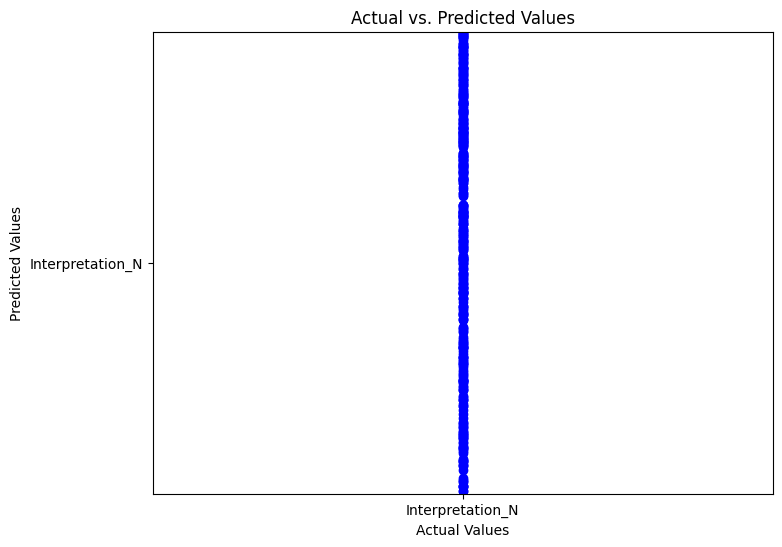

In [156]:
# Visualize the predicted values vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_predicted, color='blue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', lw=2)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

lower values of MAE, MSE, and RMSE indicate better model performance

# 2.1.4 Testing the model with test data



In [157]:

test_well_x = test_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
test_df['TEST_DT'] = lineModel.predict(test_well_x)

actual_values = test_df['Interpretation_N']
predicted_values = test_df['TEST_DT']



In [158]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Mean Absolute Error (MAE): 0.0880
Mean Squared Error (MSE): 0.0148
Root Mean Squared Error (RMSE): 0.1216


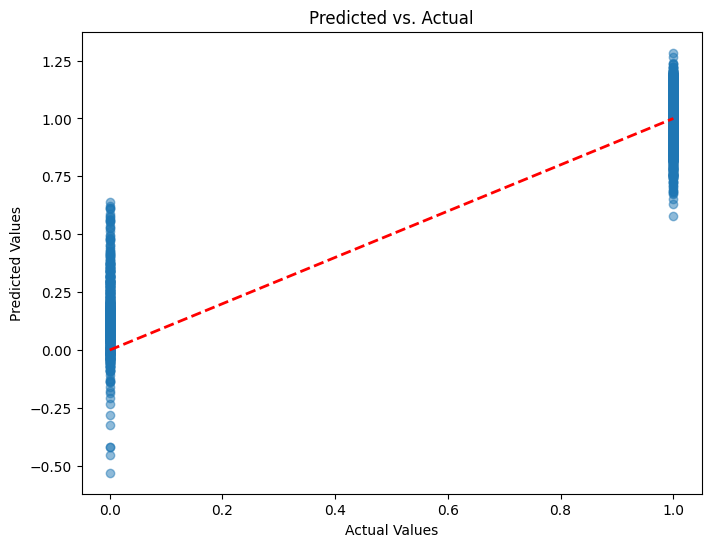

In [159]:

# Visualize the predicted values vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', lw=2)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

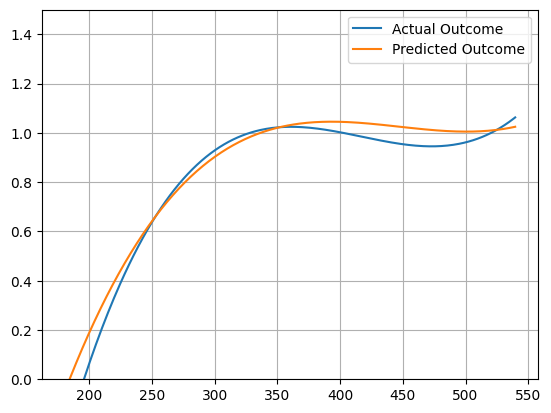

In [160]:

# Ploting the Actual Outcome and Predicted Outcome Vs well Depth
x = test_df['Depth']
y_actual = test_df['Interpretation_N']
y_predicted = test_df['TEST_DT']

# Create a smoother curve by polynomial interpolation
x_smooth = np.linspace(x.min(), x.max(), 300)
p_actual = np.polyfit(x, y_actual, 3)
p_predicted = np.polyfit(x, y_predicted, 3)

y_actual_smooth = np.polyval(p_actual, x_smooth)
y_predicted_smooth = np.polyval(p_predicted, x_smooth)

# Plot the smoothed curves
plt.plot(x_smooth, y_actual_smooth, label='Actual Outcome')
plt.plot(x_smooth, y_predicted_smooth, label='Predicted Outcome')
plt.ylim(0, 1.5)  # Adjusted y-axis limits
plt.grid()
plt.legend()
plt.show()

# 2.2 Logistic Regression Model

# 2.2.1 Selecting the features


In [161]:
from sklearn.linear_model import LogisticRegression

# Selecting training & target features
X = train_val_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
y = train_val_df[['Interpretation']]

# seperating the dataset into training and validation data
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.2)


# 2.2.2  Initialize & Train the model


In [162]:
# Initialize the logistic regression model
logRegModel = LogisticRegression()

# Train the model
logRegModel.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

# 2.2.3 Evaluare the model with validation data


In [163]:
# Predict on the validation set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

y_val_predicted= logRegModel.predict(X_val)


In [164]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_predicted)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_val, y_val_predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')


Accuracy: 0.9930
Misclassification Rate: 0.0070
True Positive Rate (Sensitivity or Recall): 0.9955
False Positive Rate: 0.0104
Specificity: 0.9896
Precision: 0.9923
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       0.99      0.99      0.99      2307
       Water       0.99      1.00      0.99      3111

    accuracy                           0.99      5418
   macro avg       0.99      0.99      0.99      5418
weighted avg       0.99      0.99      0.99      5418



(0.0, 2.0)

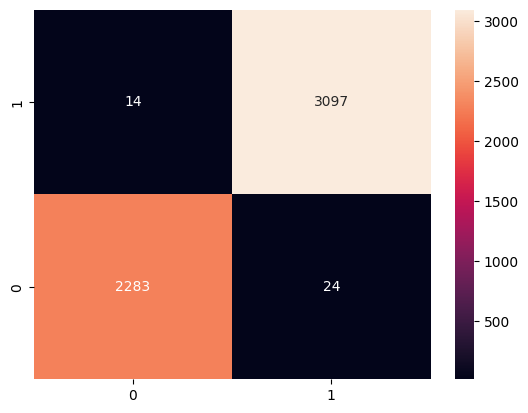

In [165]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_val, y_val_predicted),annot=True,fmt="d")
ax.set_ylim([0,2])

# 2.2.4 Testing the model with test data

In [166]:

test_well_x = test_df[[ 'GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
test_df['TEST_DT'] = logRegModel.predict(test_well_x)

# Evaluate the model on the  test set
y_actual = test_df['Interpretation']
y_predicted = test_df['TEST_DT']

In [167]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_actual, y_predicted)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_actual, y_predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')

Accuracy: 0.9933
Misclassification Rate: 0.0067
True Positive Rate (Sensitivity or Recall): 1.0000
False Positive Rate: 0.0364
Specificity: 0.9636
Precision: 0.9919
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       1.00      0.96      0.98       660
       Water       0.99      1.00      1.00      2936

    accuracy                           0.99      3596
   macro avg       1.00      0.98      0.99      3596
weighted avg       0.99      0.99      0.99      3596



(0.0, 2.0)

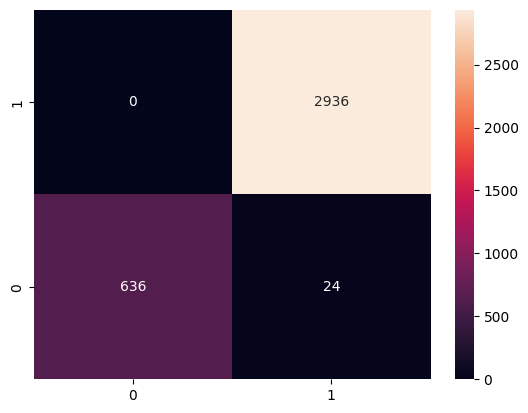

In [168]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_actual, y_predicted),annot=True,fmt="d")
ax.set_ylim([0,2])

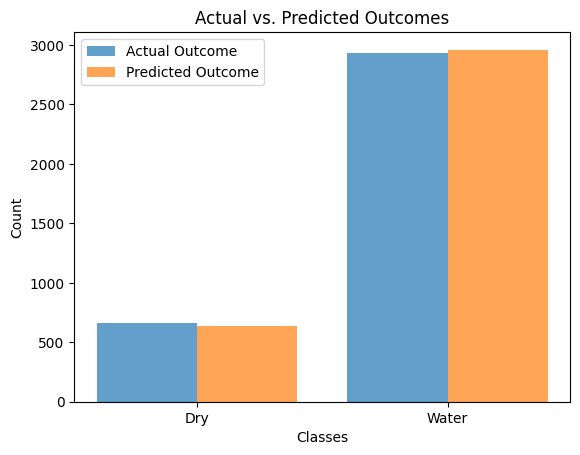

In [169]:
# create a bar plot to compare the actual and predicted outcomes
# Create an array of unique classes
classes = test_df['Interpretation'].unique()

# Count the occurrences of each class in y_actual and y_predicted
actual_counts = [sum(y_actual == cls) for cls in classes]
predicted_counts = [sum(y_predicted == cls) for cls in classes]

# Set up the positions of the bars and their width
x = range(len(classes))
width = 0.4

# Create the bar plots
plt.bar(x, actual_counts, width, label='Actual Outcome', align='center', alpha=0.7)
plt.bar([i + width for i in x], predicted_counts, width, label='Predicted Outcome', align='center', alpha=0.7)

# Set labels, title, and legend
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Actual vs. Predicted Outcomes')
plt.xticks([i + width/2 for i in x], classes)
plt.legend()

# Show the plot
plt.show()

# 2.3 Support Vector Machines (SVM)

# 2.3.1 Selecting the features


In [170]:
from sklearn.svm import LinearSVC

# Selecting training & target features
X = train_val_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
y = train_val_df[['Interpretation']]

# seperating the dataset into training and validation data
X_train, X_val, y_train, y_val =train_test_split(X, y, test_size=0.2)


# 2.3.2  Initialize & Train the model


In [171]:
# Initialize the LinearSVC model
svm_model = LinearSVC()

# Train the model
svm_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

# 2.3.3 Evaluare the model with validation data


In [172]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

y_val_pred = svm_model.predict(X_val)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_val, y_val_pred)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')


Accuracy: 0.9911
Misclassification Rate: 0.0089
True Positive Rate (Sensitivity or Recall): 0.9936
False Positive Rate: 0.0122
Specificity: 0.9878
Precision: 0.9911
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       0.99      0.99      0.99      2286
       Water       0.99      0.99      0.99      3132

    accuracy                           0.99      5418
   macro avg       0.99      0.99      0.99      5418
weighted avg       0.99      0.99      0.99      5418



(0.0, 2.0)

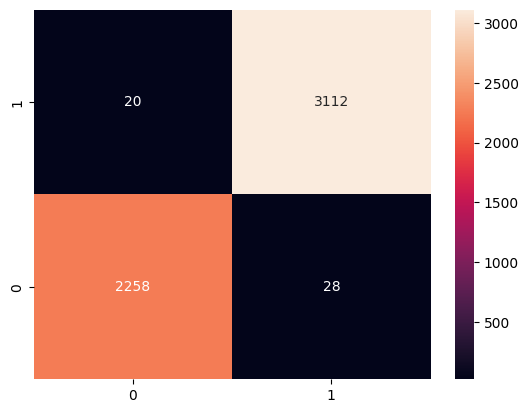

In [173]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_val, y_val_pred),annot=True,fmt="d")
ax.set_ylim([0,2])

# 2.3.4 Testing the model with test data

In [174]:
# Testing the model on selected test well
test_well_x = test_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
test_df['TEST_DT'] = svm_model.predict(test_well_x)

# Evaluate the model on the  test set
y_actual = test_df['Interpretation']
y_predicted = test_df['TEST_DT']

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_actual, y_predicted)

# Calculate metrics
total = conf_matrix.sum()
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / total
misclassification_rate = (conf_matrix[0, 1] + conf_matrix[1, 0]) / total
true_positive_rate = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
false_positive_rate = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
report_actual = classification_report(y_actual, y_predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Misclassification Rate: {misclassification_rate:.4f}')
print(f'True Positive Rate (Sensitivity or Recall): {true_positive_rate:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Actual Test Classification Report:\n{report_actual}')


Accuracy: 0.9894
Misclassification Rate: 0.0106
True Positive Rate (Sensitivity or Recall): 1.0000
False Positive Rate: 0.0576
Specificity: 0.9424
Precision: 0.9872
Actual Test Classification Report:
              precision    recall  f1-score   support

         Dry       1.00      0.94      0.97       660
       Water       0.99      1.00      0.99      2936

    accuracy                           0.99      3596
   macro avg       0.99      0.97      0.98      3596
weighted avg       0.99      0.99      0.99      3596



(0.0, 2.0)

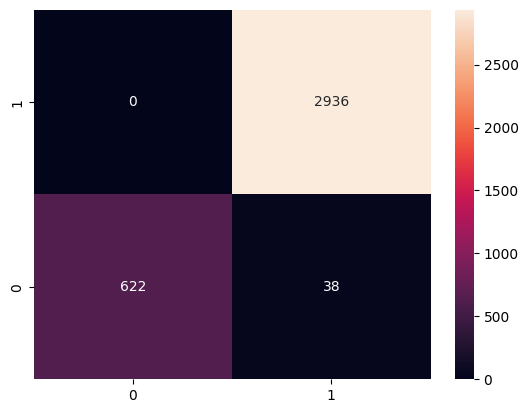

In [175]:
# Visualize the confusion matrix
ax = sns.heatmap(confusion_matrix(y_actual, y_predicted),annot=True,fmt="d")
ax.set_ylim([0,2])

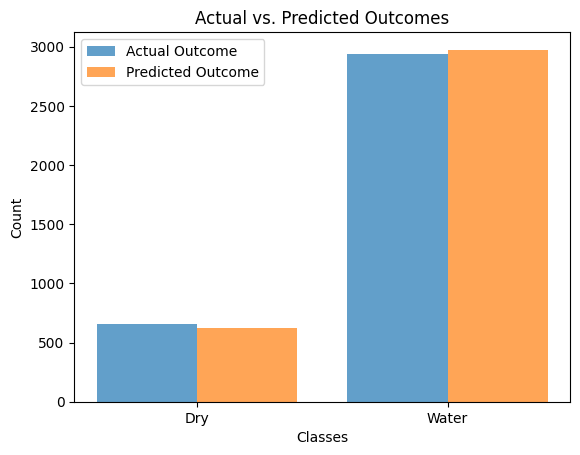

In [176]:

# create a bar plot to compare the actual and predicted outcomes
# Create an array of unique classes
classes = test_df['Interpretation'].unique()

# Count the occurrences of each class in y_actual and y_predicted
actual_counts = [sum(y_actual == cls) for cls in classes]
predicted_counts = [sum(y_predicted == cls) for cls in classes]

# Set up the positions of the bars and their width
x = range(len(classes))
width = 0.4

# Create the bar plots
plt.bar(x, actual_counts, width, label='Actual Outcome', align='center', alpha=0.7)
plt.bar([i + width for i in x], predicted_counts, width, label='Predicted Outcome', align='center', alpha=0.7)

# Set labels, title, and legend
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Actual vs. Predicted Outcomes')
plt.xticks([i + width/2 for i in x], classes)
plt.legend()

# Show the plot
plt.show()

# 2.4 Random Forest Regressor

# 2.4.1 Selecting the features


In [110]:
from sklearn.ensemble import RandomForestRegressor


In [128]:
# Loading Dataset
df = pd.read_csv('/content/sample_data/WellLoging_Dataset.csv')
print(df.columns)

Index(['Well_ID', 'Depth', 'GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON',
       'Interpretation', 'Interpretation_N'],
      dtype='object')


In [129]:
# Loading & Selecting the feature
df = pd.read_csv('/content/sample_data/WellLoging_Dataset.csv', usecols=['Well_ID', 'Depth', 'GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON',
       'Interpretation', 'Interpretation_N'])

In [130]:
df['Well_ID'].unique()

array(['1-T-209', '1-T-210', '1-T-211', '1-T-112', '1-T-213', '1-T-202'],
      dtype=object)

In [131]:
# extract the data from the dataset for training and testing
from sklearn.model_selection import train_test_split

train_val_df = df[df['Well_ID'].isin(training_wells)].copy()
test_df = df[df['Well_ID'].isin(testing_well)].copy()

# Deviding dataset to training & testing
training_wells = (['1-T-202',  '1-T-112', '1-T-213', '1-T-210'])
testing_well = (['1-T-209'])

# Selecting training & target feature
x = train_val_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
y = train_val_df[['Interpretation_N']]

In [132]:
# seperating the dataset into training and validation data
x_train, x_val, y_train, y_val =train_test_split(x, y, test_size=0.2)
# test size 0.2 the means 20% of the data will be use for testing

# 2.4.2  Initialize & Train the model


In [133]:
#Building the model
regr = RandomForestRegressor()
regr.fit(x_train, y_train)

<ipython-input-133-65698de6fa59>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(x_train, y_train)


RandomForestRegressor()

# 2.4.3 Evaluare the model with validation data


In [134]:
# Test the model with validation data
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

y_pred = regr.predict(x_val)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')



Mean Absolute Error (MAE): 0.003276658270361041
Mean Squared Error (MSE): 0.0015838161209068009
Root Mean Squared Error (RMSE): 0.03979718734919342


Interpretation:
- MAE  indicates that, on average, the predictions are very close to the actual values
- The squared differences between predicted values
- RMSE predictions are very close to the actual values.

Scatter plot: Points clustered around the diagonal line indicate accurate predictions, while points scattered away from the line indicate errors in prediction.
In this case all points are falling along the diagonal line (y = x), indicating a perfect prediction.

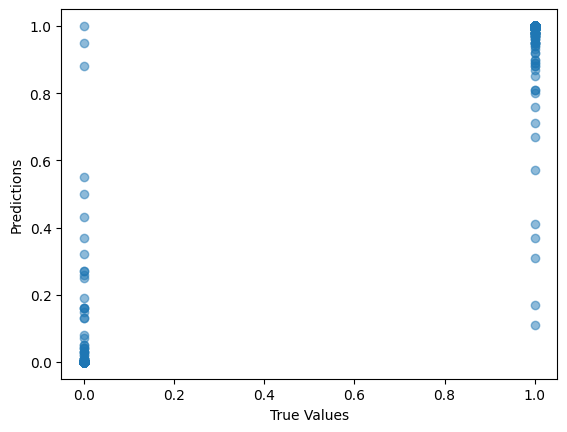

In [135]:
# Scatter plot to compare the actual and predicted values.
plt.scatter(y_val, y_pred, alpha=0.5)  # Scatter plot
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# 2.4.4 Testing the model with test data

In [136]:
# Testing the model with test dat
test_well_x = test_df[['GAM(NAT)', 'RES(16N)', 'RES(64N)', 'NEUTRON']]
test_df['TEST_DT'] = regr.predict(test_well_x)

actual_values = test_df['Interpretation_N']
predicted_values = test_df['TEST_DT']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 0.02124026696329255
Mean Squared Error (MSE): 0.007309899888765295
Root Mean Squared Error (RMSE): 0.08549795254136379


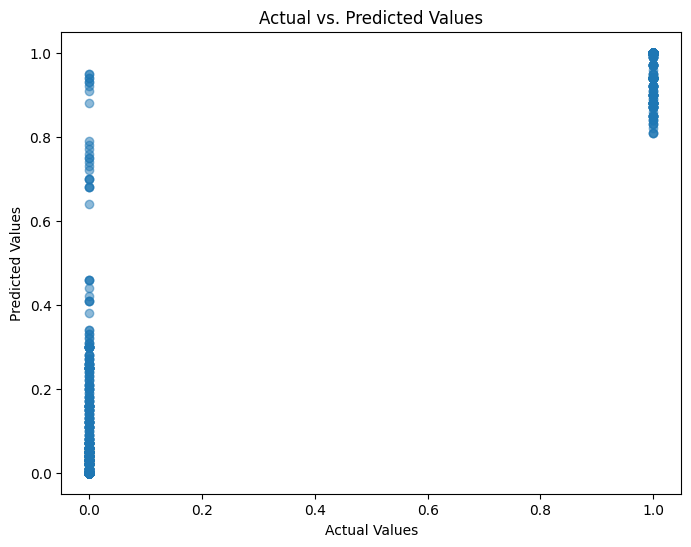

In [137]:
# Scatter plot to compare the actual and predicted values.
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)  # Scatter plot

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

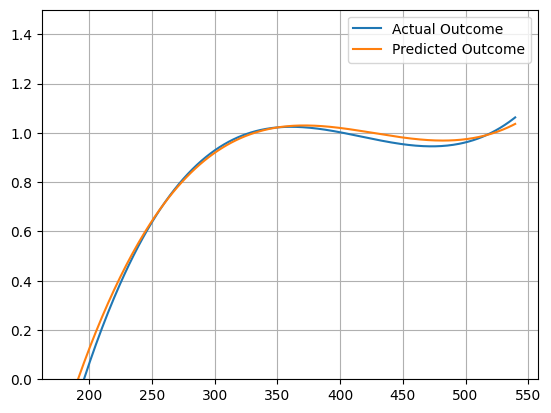

In [138]:

# Ploting the Actual Outcome and Predicted Outcome Vs well Depth
x = test_df['Depth']
y_actual = test_df['Interpretation_N']
y_predicted = test_df['TEST_DT']

# Create a smoother curve by polynomial interpolation
x_smooth = np.linspace(x.min(), x.max(), 300)
p_actual = np.polyfit(x, y_actual, 3)
p_predicted = np.polyfit(x, y_predicted, 3)

y_actual_smooth = np.polyval(p_actual, x_smooth)
y_predicted_smooth = np.polyval(p_predicted, x_smooth)

# Plot the smoothed curves
plt.plot(x_smooth, y_actual_smooth, label='Actual Outcome')
plt.plot(x_smooth, y_predicted_smooth, label='Predicted Outcome')
plt.ylim(0, 1.5)  # Adjusted y-axis limits
plt.grid()
plt.legend()
plt.show()

Feature Importance Plot:

This plot shows the relative importance of each feature in making accurate predictions.
For understanding which features are contributing the most to the model's performance.

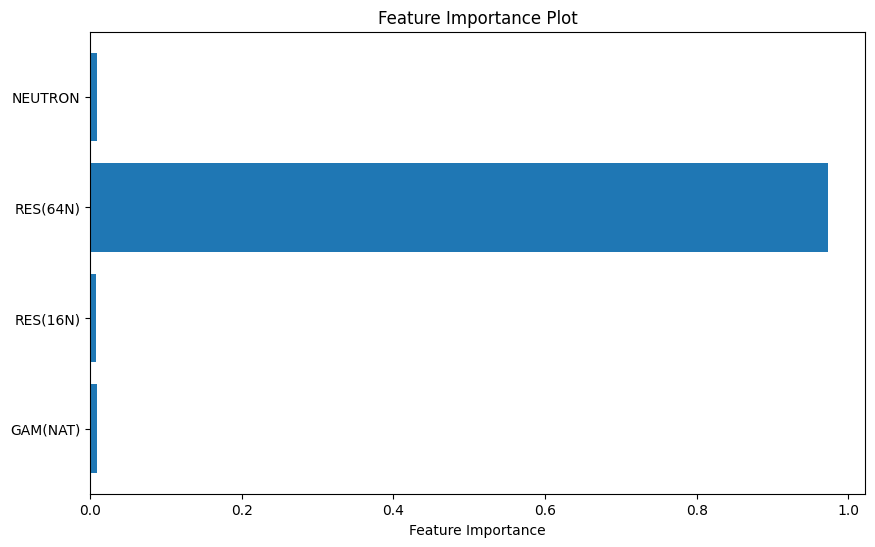

In [139]:
feature_importances = regr.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()


Actual vs. Predicted Plot:.
Shows how well the model's predictions align with the actual data points.

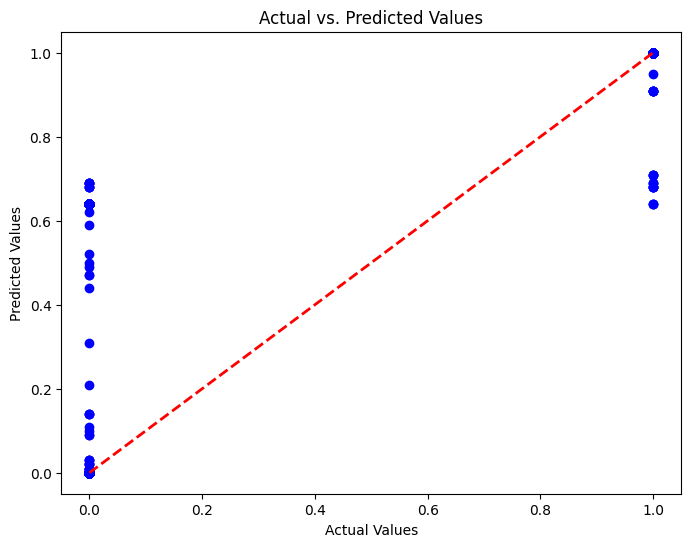

In [124]:
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_predicted, color='blue')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--', lw=2)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


To visualize the distribution of residuals, create a histogram or a density plot. This will help to understand if the residuals are normally distributed or if there are any patterns or outliers.

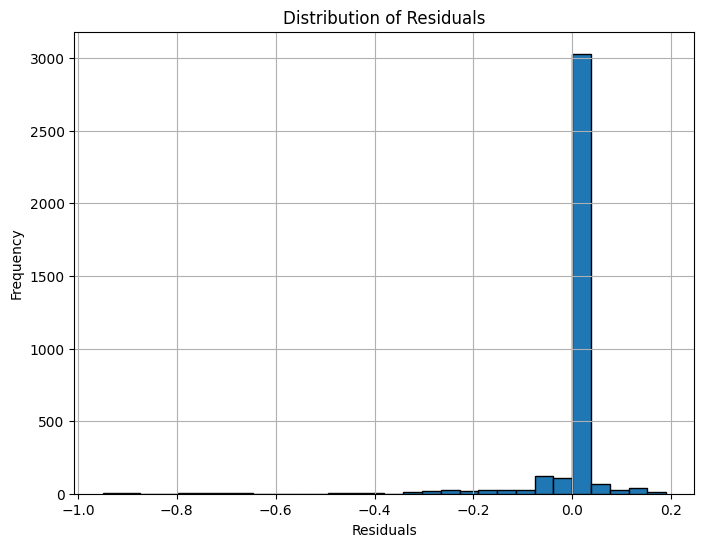

In [140]:


# Calculate residuals
residuals = [true - pred for true, pred in zip(y_actual, y_predicted)]

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()


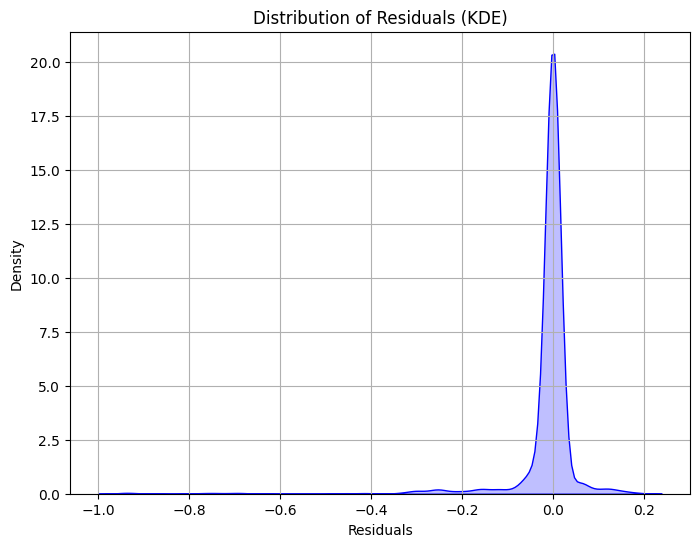

In [141]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.kdeplot(residuals, color='b', fill=True)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Distribution of Residuals (KDE)')
plt.grid(True)
plt.show()